# 1. Introduction

In this project we will take a look at the Metro Interstate Traffic Volume data.

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

This is multivariate time series which has a mix of categorical features (e.g. calendar holidays, weather descriptions), and numeric features about temperature, weather and traffic.

The goal is to predict future traffic using past calendar, time, weather and traffic data.

We will explore the use of the model proposed in [Deep and Confident Prediction for Time Series at Uber](https://arxiv.org/abs/1709.01907) for this problem.

This research introduces a method for calculating uncertainty bounds in time series prediction using Monte Carlo dropout. Their model also introduces a way to incorporate exogenous non-time series information such as whether the predictions are to fall on a public holiday.

In this notebook we will explore the data, and preprocess and prepare it for training. We will then place the code in a neater `data.py` script for reuse.

## 1.1 First look at the data

```
holiday             │ Categorical US National holidays plus regional holiday, Minnesota State Fair
temp                │ Numeric Average temp in kelvin
rain_1h             │ Numeric Amount in mm of rain that occurred in the hour
snow_1h             │ Numeric Amount in mm of snow that occurred in the hour
clouds_all          │ Numeric Percentage of cloud cover
weather_main        │ Categorical Short textual description of the current weather
weather_description │ Categorical Longer textual description of the current weather
date_time           │ DateTime Hour of the data collected in local CST time
traffic_volume      │ Numeric Hourly I-94 ATR 301 reported westbound traffic volume
```

### 1.1.1 Load data

In [1]:
from pathlib import Path
import subprocess
import pandas as pd

DATA = 'data'
DATASET = 'Metro_Interstate_Traffic_Volume.csv'
# create data dir
Path(DATA).mkdir(parents=True, exist_ok=True)

# download and extract data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'
subprocess.run(['curl', '-o', f'{DATA}/{DATASET}.gz', url])
subprocess.run(['gzip', '-d', f'{DATA}/{DATASET}.gz'])

# read in data with pandas
df = pd.read_csv(f'{DATA}/{DATASET}')
df.head(3)

time_col = 'date_time'

### 1.1.2 Cast datetime

In [2]:
# cast date_time to time type
df[time_col] = pd.to_datetime(df[time_col])

In [3]:
# sort dataframe by time
df = df.sort_values(time_col)

### 1.1.3 Check for duplicated rows

Some timestamps are duplicated. This appears to reflect either a change in weather conditions or additional information about the weather.

The other features such as temp and traffic volume remain the same for duplicated rows.

For the purposes of creating trainable data, we will keep the lastest row and discard the previous ones.

In [4]:
df[df[time_col].duplicated(keep=False)].head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
178,None,281.25,0.0,0.0,99,Rain,light rain,2012-10-10 07:00:00,6793
179,None,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 07:00:00,6793
180,None,280.10,0.0,0.0,99,Rain,light rain,2012-10-10 08:00:00,6283
181,None,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 08:00:00,6283
182,None,279.61,0.0,0.0,99,Rain,light rain,2012-10-10 09:00:00,5680
183,None,279.61,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 09:00:00,5680
269,None,282.43,0.0,0.0,57,Drizzle,light intensity drizzle,2012-10-14 09:00:00,2685
270,None,282.43,0.0,0.0,57,Mist,mist,2012-10-14 09:00:00,2685
271,None,282.43,0.0,0.0,57,Haze,haze,2012-10-14 09:00:00,2685
272,None,282.33,0.0,0.0,57,Drizzle,light intensity drizzle,2012-10-14 10:00:00,3370


In [5]:
df = df.iloc[df[time_col].drop_duplicates(keep='last').index]

## 1.2 Missing data

The dataset has hourly rows from 9am Oct. 2nd 2012 to 11pm Sept. 30th 2018.

Over this time range 40,575 rows are present out of 52,551 hours, and therefore 11,976 hours are missing.

In [6]:
# get the first and last timestamps
start, end = df.date_time.iloc[[0,-1]].values

# get a list of hourly timestamps in this range
full_range = pd.date_range(start, end, freq='H')

full_range.shape[0], full_range.shape[0]- df.shape[0]

(52551, 11976)

In [7]:
df = pd.DataFrame(full_range, columns=[time_col]).merge(df, on=time_col, how='outer')

In [8]:
df = df.set_index(time_col)

There is a gap of almost a year from mid 2014 to mid 2015. There are also noticeable  gaps in late 2013 and late 2015. These gaps should probably be discarded from the dataset completely rather than attempting to impute them.

Some of the intermittent gaps elsewhere may be able to be imputed.

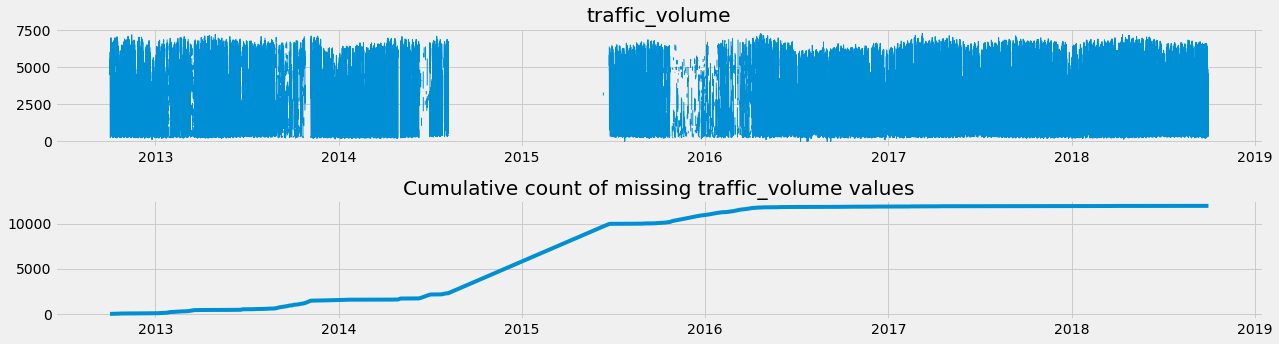

In [40]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
plt.style.use('fivethirtyeight')

response_col = 'traffic_volume'

fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df[response_col],'-', lw=1)
axs[0].set_title(response_col)
axs[1].plot(np.cumsum(df[response_col].isna()),'-')
axs[1].set_title(f'Cumulative count of missing {response_col} values')
plt.tight_layout()

## 1.3 Check data for anomalies

We want to make sure there are no strange values in the data before using it to train our model.

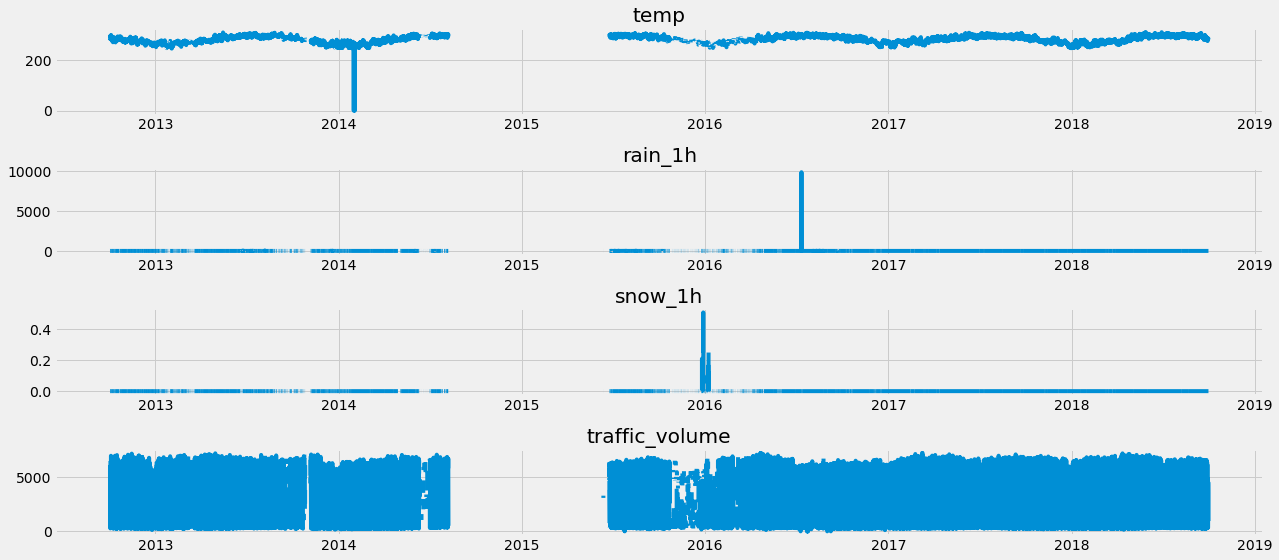

In [14]:
columns = ['temp', 'rain_1h', 'snow_1h', 'traffic_volume']
fig, axs = plt.subplots(len(columns), 1, figsize=(18,len(columns)*2))
for c,col in enumerate(columns):
    axs[c].plot(df[col])
    axs[c].set_title(col)
plt.tight_layout()

### 1.3.1 `rain_1h` anomaly

There does appear to have been extreme rain on July 11 2016 https://www.weather.goxv/dlh/flash-flooding-2016-07-11

However the recorded value in dataset of 9831.3mm is too extreme for 1 hour and would have broken the US _24 hour_ record several times over

https://en.wikipedia.org/wiki/List_of_wettest_tropical_cyclones_in_the_United_States

We can therefore reasonably conclude that this datapoint has been entered incorrectly. We will replace the value with the second maximum observed in the dataset as a proxy to the extreme weather event.

In [15]:
# get the second largest rain value
second_largest_rain_1h = df['rain_1h'].sort_values(ascending=False)[1]
second_largest_rain_1h

55.63

In [16]:
rain_1h_mask = df['rain_1h'] > 5000
largest_rain_1h_idx = np.where(rain_1h_mask)[0][0]

In [17]:
df.at[df.iloc[largest_rain_1h_idx].name, 'rain_1h'] = second_largest_rain_1h

### 1.3.2 `temp` anomaly

There are four values of temp recorded at 0 Kelvin. 

This is Absolute Zero (−273.15°C) which has never actually been observed anywhere [1].

We will therefore replace this series of anomaly values by imputing them with an interpolation between the preceeding and proceeding temp values.

[1] https://en.wikipedia.org/wiki/Absolute_zero#Very_low_temperatures

In [18]:
temp_mask = df['temp'] < 100
smallest_temp_idx = np.where(temp_mask)[0][0]
df.iloc[smallest_temp_idx-1:smallest_temp_idx+5][['temp']]

,temp
date_time,
2014-01-31 02:00:00,255.93
2014-01-31 03:00:00,0.00
2014-01-31 04:00:00,0.00
2014-01-31 05:00:00,0.00
2014-01-31 06:00:00,0.00
2014-01-31 07:00:00,255.93


In [19]:
# get interpolated value
temp_imputate_value = df['temp'].iloc[[smallest_temp_idx-1,smallest_temp_idx+5]].mean()

# fill in anomalous values
for i in range(smallest_temp_idx,smallest_temp_idx+4):
    idx = df.iloc[i].name
    df.at[idx, 'temp'] = temp_imputate_value

In [20]:
df.iloc[smallest_temp_idx-1:smallest_temp_idx+5][['temp']]

,temp
date_time,
2014-01-31 02:00:00,255.93
2014-01-31 03:00:00,255.93
2014-01-31 04:00:00,255.93
2014-01-31 05:00:00,255.93
2014-01-31 06:00:00,255.93
2014-01-31 07:00:00,255.93


## 1.4 Create features

We need to convert the categorical string features like `weather_description` and `holiday` into one-hot encodings so that this information can be fed into a neural network model.

We also want to encode the time information (e.g. hour of day) as this seems like a useful feature for traffic volume prediction.

### 1.4.1 One hot encode `weather_description`

In [10]:
df['weather_description'].unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', nan, 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog', 'drizzle',
       'moderate rain', 'proximity thunderstorm',
       'proximity thunderstorm with rain', 'heavy snow',
       'heavy intensity rain', 'snow', 'shower snow',
       'light rain and snow', 'SQUALLS', 'thunderstorm with heavy rain',
       'thunderstorm with rain', 'thunderstorm with light rain',
       'heavy intensity drizzle', 'Sky is Clear',
       'thunderstorm with light drizzle', 'thunderstorm',
       'very heavy rain', 'proximity thunderstorm with drizzle',
       'light snow', 'proximity shower rain',
       'light intensity shower rain', 'light shower snow', 'smoke',
       'shower drizzle'], dtype=object)

In [11]:
dummies = pd.get_dummies(df['weather_description'], prefix='weather')
df[dummies.columns] = dummies

### 1.4.2 One hot encode `holiday`

In [12]:
df['holiday'].unique()

array(['None', nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [13]:
dummies = pd.get_dummies(df['holiday'], prefix='holiday')
df[dummies.columns] = dummies


### 1.4.3 Create seasonal features


#### Hour of day

In [22]:
hour_sin = np.sin(2*np.pi*(df.index.hour.values/24))
hour_cos = np.cos(2*np.pi*(df.index.hour.values/24))

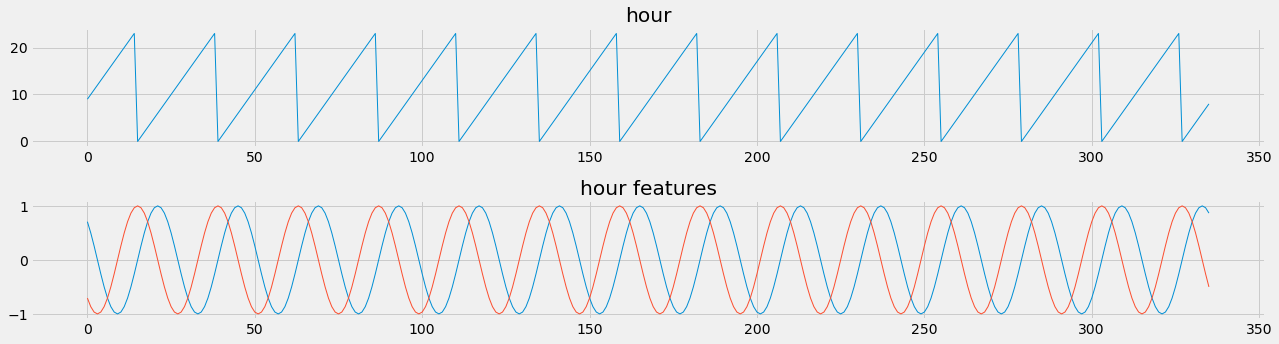

In [23]:
fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df.index.hour[:24*7*2],'-', lw=1)
axs[0].set_title('hour')
axs[1].plot(hour_sin[:24*7*2],'-', lw=1)
axs[1].plot(hour_cos[:24*7*2],'-', lw=1)
axs[1].set_title('hour features')
plt.tight_layout()

In [24]:
df['hour_sin'] = hour_sin
df['hour_cos'] = hour_cos

#### Day of week

In [25]:
weekday_sin = np.sin(2*np.pi*(df.index.weekday.values/7))
weekday_cos = np.cos(2*np.pi*(df.index.weekday.values/7))

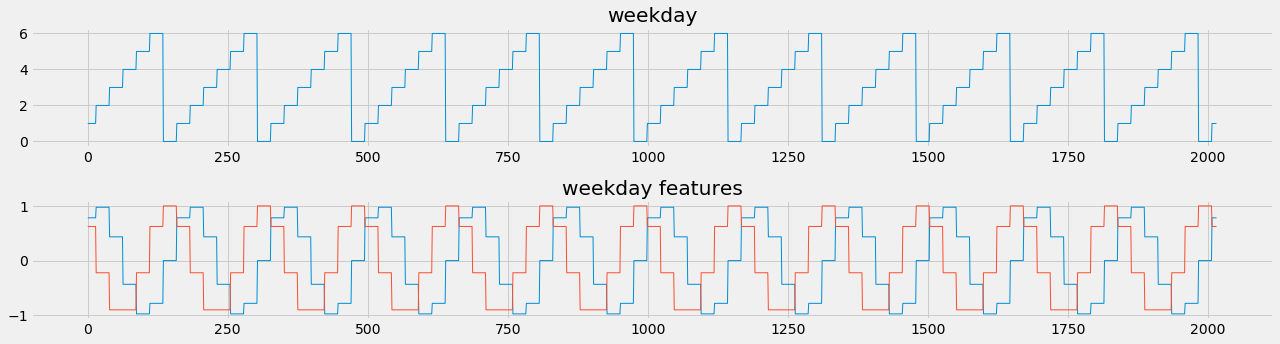

In [26]:
fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df.index.weekday[:24*7*12],'-', lw=1)
axs[0].set_title('weekday')
axs[1].plot(weekday_sin[:24*7*12],'-', lw=1)
axs[1].plot(weekday_cos[:24*7*12],'-', lw=1)
axs[1].set_title('weekday features')
plt.tight_layout()

In [27]:
df['weekday_sin'] = weekday_sin
df['weekday_cos'] = weekday_cos

#### Week of year

In [28]:
yearweek_sin = np.sin(2*np.pi*(df.index.week.values/52))
yearweek_cos = np.cos(2*np.pi*(df.index.week.values/52))

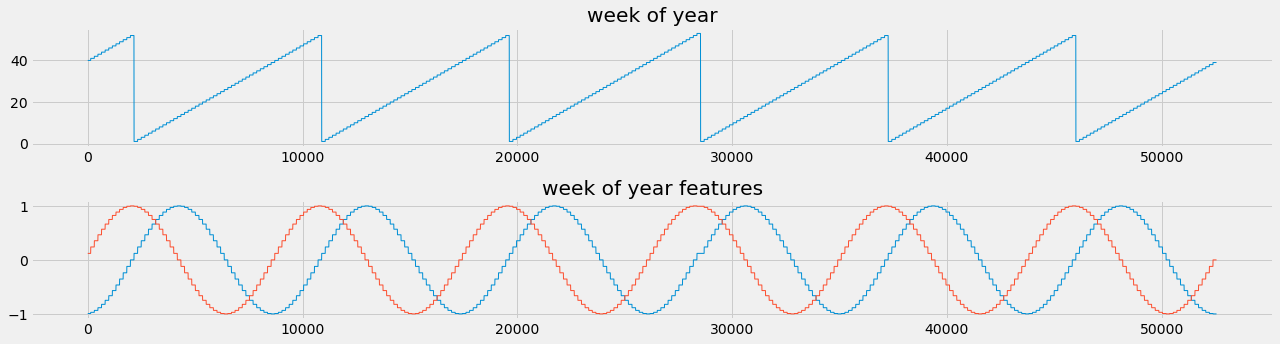

In [29]:
fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df.index.week,'-', lw=1)
axs[0].set_title('week of year')
axs[1].plot(yearweek_sin,'-', lw=1)
axs[1].plot(yearweek_cos,'-', lw=1)
axs[1].set_title('week of year features')
plt.tight_layout()

In [30]:
df['yearweek_sin'] = yearweek_sin
df['yearweek_cos'] = yearweek_cos

## 1.5 Train, valid, test split

We will use last 6 months as the test data, the 6 months prior to that as validation data, and everything before as training data.

### 1.5.1 Split the dataset

In [ ]:
# drop the string features, we have now one-hot encoded these
df = df.drop(['weather_main','weather_description','holiday'],axis=1)

In [32]:
test_start_time  = df.index[-1] - np.timedelta64(30*6,  'D')
valid_start_time = df.index[-1] - np.timedelta64(30*12, 'D')

In [33]:
ranges = {
    'train': (df.index[0], valid_start_time),
    'valid': (valid_start_time, test_start_time),
    'test':  (test_start_time, df.index[-1])
}

In [34]:
datasets = {}
time_to_index = lambda time: np.where(df.index == time)[0][0]

datasets['train'] = df.iloc[:time_to_index(valid_start_time)]
datasets['valid'] = df.iloc[time_to_index(valid_start_time):
                            time_to_index(test_start_time)]
datasets['test']  = df.iloc[time_to_index(test_start_time):]

for key,dataset in datasets.items():
    print(dataset.shape[0], key, 'rows from', ranges[key][0], 'to', ranges[key][1])

43910 train rows from 2012-10-02 09:00:00 to 2017-10-05 23:00:00
4320 valid rows from 2017-10-05 23:00:00 to 2018-04-03 23:00:00
4321 test rows from 2018-04-03 23:00:00 to 2018-09-30 23:00:00


### 1.5.2 Create the training/prediction samples

We will use 48 steps of input data and predict the next 12 steps. 

We can now create the respective supervised samples for training, validation and testing out of the split datasets.

For now, we will drop any samples which have NaNs. However we may try methods to impute values where there are not significant gaps.

In [35]:
n_input_steps = 48
n_pred_steps  = 12

In [36]:
for key,dataset in datasets.items():
    dataset = datasets[key]
    n_cols = dataset.shape[1]
    dataset = dataset.values.astype(np.float64)
    
    idxs = np.arange(dataset.shape[0])
    n_timesteps = n_input_steps + n_pred_steps
    n_samples = dataset.shape[0] - n_timesteps + 1
    stride = idxs.strides[0]
    sample_idxs = np.lib.stride_tricks.as_strided(idxs, shape=(n_samples, n_timesteps), strides=(stride, stride))
    
    samples = dataset[sample_idxs]
    useable = np.all(~np.isnan(samples.reshape(-1, n_timesteps*n_cols)),axis=-1)
    s = samples[useable]
    
    print(s.shape[0], f'samples of {n_input_steps} input steps and {n_pred_steps} output steps in', key)


16625 samples of 48 input steps and 12 output steps in train
3534 samples of 48 input steps and 12 output steps in valid
4020 samples of 48 input steps and 12 output steps in test


This concludes the notebook, we will transfer the code to be reused into the `data.py` module